In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joypy
import helper_functions
from matplotlib.lines import Line2D
from scipy.stats import gaussian_kde
from matplotlib.patches import Patch

helper = helper_functions.HelperFunctions()

sns.set_palette('viridis')

In [2]:
data_path = 'C:/Users/Arkady/Google Drive/data/beyond_the_reach'
figure_path = 'C:/Users/Arkady/Dropbox/Research/Journal papers/2018 Beyond the reach/figures'

figure_format = '.png'

index=['subj_id', 'task', 'trial_no']

choices = pd.read_csv(os.path.join(data_path, 'choices_processed.txt'))
dynamics = pd.read_csv(os.path.join(data_path, 'dynamics_processed.txt'))

choices = choices.set_index(index, drop=False)
dynamics = dynamics.set_index(index, drop=False)

dynamics = dynamics.join(choices.option_chosen)

choices['Delta_q'] = choices.groupby(['task', 'option_chosen'])['Delta'].transform(
                     lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))


# choices['Lambda_q'] = choices.groupby(['task', 'option_chosen'])['Lambda'].transform(
#                      lambda x: pd.qcut(x, q=3, labels=['Low', 'Medium', 'High']))

# choices['Lambda_q'] = pd.qcut(choices.Lambda, q=3, labels=['Low', 'Medium', 'High'])

# choices['Delta_q'] = pd.qcut(choices.Delta, q=2, labels=['Low', 'High'])
# choices['Delta_sign'] = np.sign(choices.Delta)

dynamics['Lambda_q'] = choices['Lambda_q']
dynamics['Delta_q'] = choices['Delta_q']

C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: 'task' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()


In [3]:
dynamics_walking = dynamics.loc[dynamics.task=='walking', :]
dynamics_mouse = dynamics.loc[dynamics.task=='mouse', :]

choices_walking = choices.loc[choices.task=='walking', :]
choices_mouse = choices.loc[choices.task=='mouse', :]

# Mean trajectories

In [4]:
def get_average_trajectories(dynamics, variables):
    cols = dynamics.index.names + variables    
    dynamics_transposed = dynamics.groupby(by = cols). \
                    apply(lambda x: x.loc[:, ['x', 'y']].reset_index(drop=True).T)
    cols += ['x/y']
    dynamics_transposed.index.names = cols
    
    subj_mean_traj = dynamics_transposed.groupby(level=variables + ['x/y']).apply(np.mean).stack()
    
    subj_mean_traj.index.names = variables + ['x/y', 't']
    subj_mean_traj = subj_mean_traj.unstack('x/y')
    return subj_mean_traj

mean_traj_walking = get_average_trajectories(dynamics_walking, ['option_chosen', 'Delta_q'])
mean_traj_mouse = get_average_trajectories(dynamics_mouse, ['option_chosen', 'Delta_q'])

mean_traj_walking_no_com = get_average_trajectories(dynamics_walking[~choices_walking.is_com], 
                                                    ['option_chosen', 'Delta_q'])
mean_traj_mouse_no_com = get_average_trajectories(dynamics_mouse[~choices_mouse.is_com], 
                                                  ['option_chosen', 'Delta_q'])

C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'subj_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'task' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'trial_no' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Arkady\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key 

In [11]:
def plot_mean_trajectories(mean_trajectories, var='Lambda_q', plot_bar=False):
    fig, ax = plt.subplots(1, figsize=(10, 10))
#     plt.set_cmap('viridis')
    ax.set_aspect(1, adjustable='datalim')
    colors = {'Low': 'C0',
              'Medium': 'C3',
              'High': 'C5'}
    
    for name, group in mean_trajectories.groupby(['option_chosen', var]):
        ax.plot(mean_trajectories.loc[name].x, mean_trajectories.loc[name].y, 
                lw=4, color=colors[name[1]])
    ax.text(s='Larger \nbut later', x=0.85, y=1.05, fontsize=26, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    ax.text(s='Smaller \nbut sooner', x=0.15, y=1.05, fontsize=26, 
            horizontalalignment='center',verticalalignment='center', transform=ax.transAxes)
    
    if plot_bar:
        x_bar = [-0.2, 0.2]
        y_bar = -0.05
        ax.plot(x_bar, [y_bar, y_bar], lw=5, color='grey')
    
    ax.tick_params(axis='both', which='major', labelsize=24)

    custom_lines = [Line2D([0], [0], color='C0', lw=4),
                    Line2D([0], [0], color='C3', lw=4),
                    Line2D([0], [0], color='C5', lw=4)]

    ax.legend(custom_lines, ['Low $\Delta$', 'Medium $\Delta$', 'High $\Delta$'], fontsize=26, loc=5)
#     ax.legend()

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


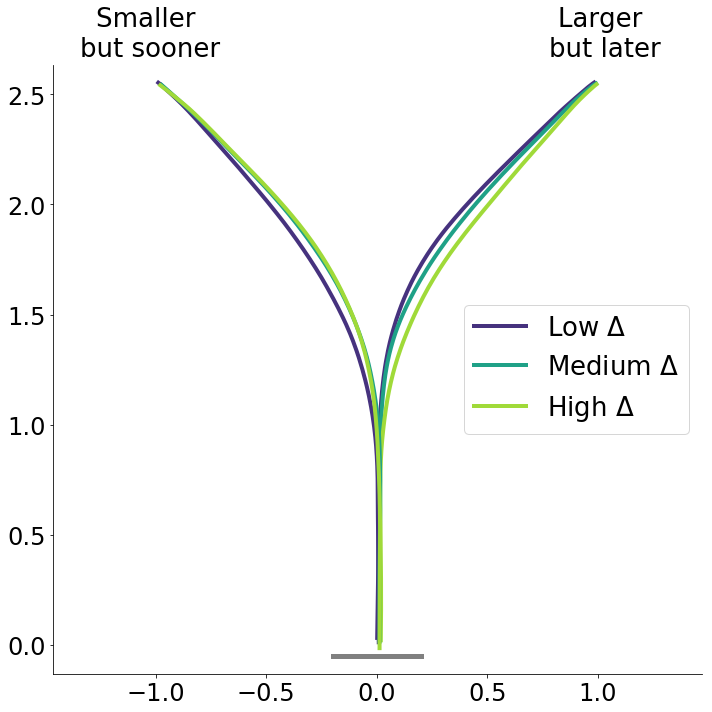

In [12]:
plot_mean_trajectories(mean_traj_walking, var='Delta_q', plot_bar=True)
plt.savefig(os.path.join(figure_path, 'mean_traj_walking'+figure_format))

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


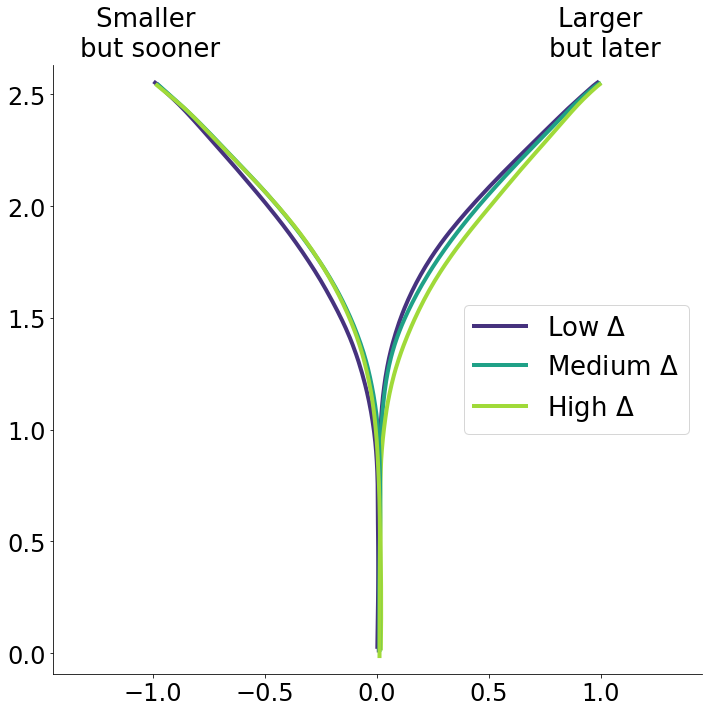

In [157]:
plot_mean_trajectories(mean_traj_walking_no_com, var='Delta_q')
plt.savefig(os.path.join(figure_path, 'mean_traj_walking_no_com'+figure_format))

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


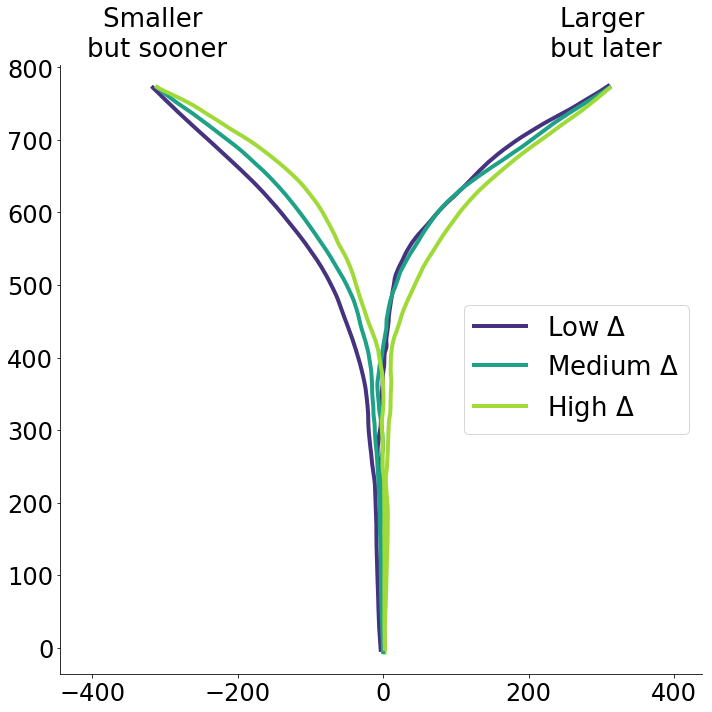

In [158]:
plot_mean_trajectories(mean_traj_mouse, var='Delta_q')
plt.savefig(os.path.join(figure_path, 'mean_traj_mouse'+figure_format))

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


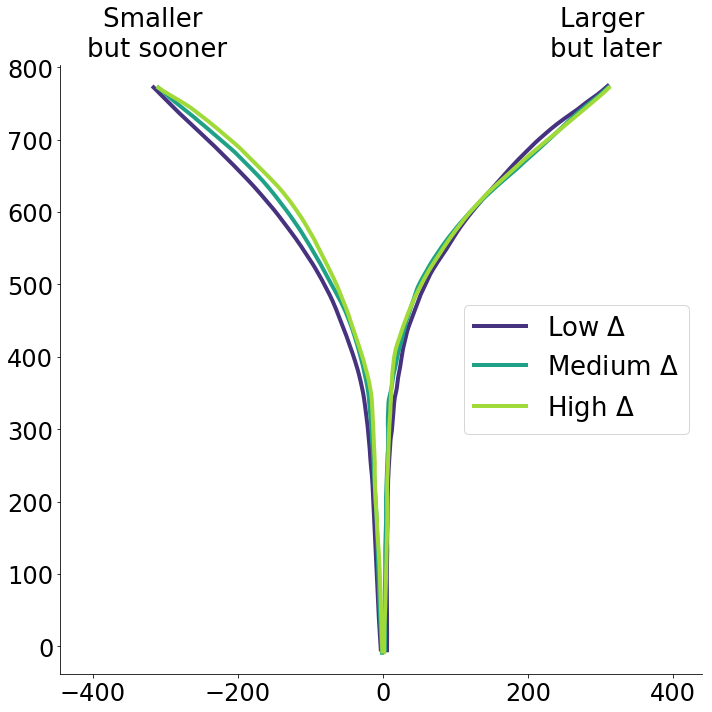

In [159]:
plot_mean_trajectories(mean_traj_mouse_no_com, var='Delta_q')
plt.savefig(os.path.join(figure_path, 'mean_traj_mouse_no_com'+figure_format))

# Regression plots

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


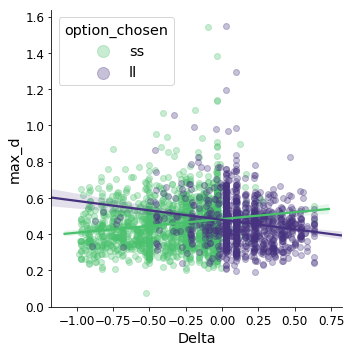

In [11]:
sns.lmplot(data=choices_walking, x='Delta', y='max_d', hue='option_chosen', 
           palette=dict(ss="C4", ll="C0"), legend_out=False, scatter_kws={'alpha':0.3})

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


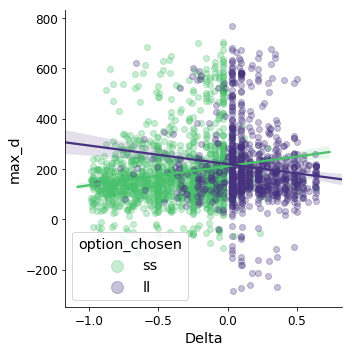

In [12]:
sns.lmplot(data=choices_mouse, x='Delta', y='max_d', hue='option_chosen', 
           palette=dict(ss="C4", ll="C0"), legend_out=False, scatter_kws={'alpha':0.3})

# Posterior plots

TODO
* add column/row labels (task, dv)
* add legend on one of the axes(ss/ll)

In [22]:
def plot_posterior_kde(posterior_samples, colors, alpha, ax):
    for choice in ['ss', 'll']:
        samples = posterior_samples.loc[posterior_samples.option_chosen==choice, 'beta']
        kde = gaussian_kde(samples)
        x_grid = np.linspace(samples.min(), samples.max(), 51)

        ax.plot(x_grid, kde(x_grid), color=colors[choice], alpha=alpha)

        ax.fill_between(x_grid, kde(x_grid), color=colors[choice], alpha=alpha,
                        where=(x_grid>samples.quantile(0.025))&(x_grid<samples.quantile(0.975)))

def plot_posterior_comparison(iv, task, dv, exclude_com, colors, ax):
    file_name = 'posterior_csv/%s/posterior_%s%s_%s.csv' % (iv, task, '_no_com' if exclude_com else '', dv)
    posterior_samples = (pd.read_csv(file_name)
                             .filter(regex=('b_%s:option_chosen.*' % (iv)))
                             .stack()
                             .reset_index()
                             .drop('level_0', axis=1)
                             .rename(index=str, columns={'level_1': 'option_chosen', 0: 'beta'}))
    posterior_samples['option_chosen'] = posterior_samples['option_chosen'].str[-2:]
    alpha = 0.3 if exclude_com else 0.9
    plot_posterior_kde(posterior_samples, colors, alpha, ax)
    
    x_max = 1.1*max(abs(posterior_samples.beta))
    ax.set_xlim((-x_max, x_max))
    ax.set_xlabel(r'$\beta_{\%s}$' % (iv))
    ax.set_ylabel('pdf')

def plot_all_posteriors(iv):
    colors={'ll': 'C0', 'ss': 'C4'}
    
    fig, axes = plt.subplots(2,2, figsize=(10,5))
    i = 0
    for task in ['walking', 'mouse']:
        for dv in ['max_d', 'RT']:
            ax = axes.flatten()[i]
            plot_posterior_comparison(iv, task, dv, exclude_com=True, colors=colors, ax=ax)
            plot_posterior_comparison(iv, task, dv, exclude_com=False, colors=colors, ax=ax)
            ax.set_title(task + ' ' + dv.replace('_', '-'))
            i+=1
    
    legend_elements = [Patch(facecolor=colors[choice], label=choice) for choice in ['ss', 'll']]

    fig.legend(handles=legend_elements, title='Choice', title_fontsize=16,
               loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.savefig(os.path.join(figure_path, 'posterior_' + iv + figure_format), dpi=300)

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


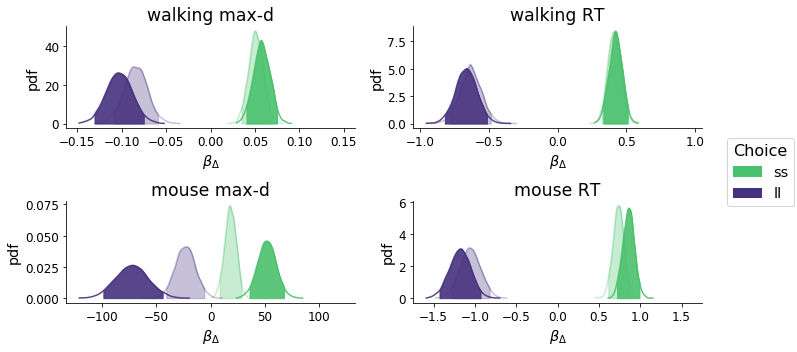

C:\Users\Arkady\Anaconda3\lib\site-packages\matplotlib\figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


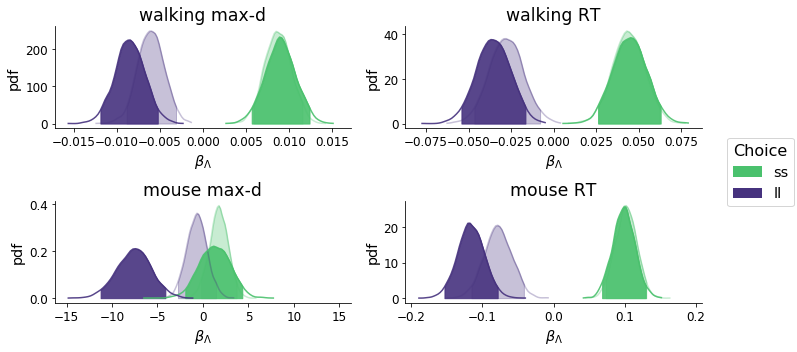

In [23]:
plot_all_posteriors(iv='Delta')

plot_all_posteriors(iv='Lambda')

In [20]:
len(choices_mouse[~choices_mouse.is_com])/len(choices_mouse)

0.9088353413654618

In [21]:
len(choices_walking[~choices_walking.is_com])/len(choices_walking)

0.9893920848633211